In [17]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# Dataset Definition
# --------------------------
from sklearn.preprocessing import StandardScaler

class BatteryDataset(Dataset):
    def __init__(self, pkl_paths):
        self.paths = pkl_paths
        self.scaler = StandardScaler()

        # 모든 데이터를 flatten 후 fit (학습셋에 대해서만)
        all_data = []
        for path in self.paths:
            x = torch.load(path, weights_only=False)[0]
            all_data.append(x)
        all_data = np.concatenate(all_data, axis=0)
        self.scaler.fit(all_data)
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)
        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)
        return x, y


In [18]:
class BatteryTestDataset(Dataset):
    def __init__(self, pkl_paths, scaler):
        self.paths = pkl_paths
        self.scaler = scaler

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = torch.load(path, weights_only=False)
        x = data[0]
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype=torch.float32)
        label_raw = float(data[1]['label'])
        label = 1.0 if label_raw == 10.0 else 0.0
        y = torch.tensor(label, dtype=torch.float32)
        return x, y


In [11]:

# --------------------------
# LSTM Model
# --------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝
        return out.squeeze(1)


In [19]:

# --------------------------
# Prepare Data
# --------------------------
train_paths = glob('./dataset/battery_brand1/train/*.pkl')
test_paths = glob('./dataset/battery_brand1/test/*.pkl')

# 클래스별 비율
normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
abnormal_count = sum(int(torch.load(p)[1]['label']) == 10 for p in train_paths)
pos_weight = torch.tensor([normal_count / abnormal_count])

train_dataset = BatteryDataset(train_paths)
test_dataset = BatteryTestDataset(test_paths,  scaler=train_dataset.scaler)
train_loader = DataLoader(train_dataset, batch_size=512*4, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512*4,  pin_memory=True)


/tmp/ipykernel_2010955/3184336798.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_count = sum(int(torch.load(p)[1]['label']) == 0 for p in train_paths)
/tmp/ipyke

In [25]:

# --------------------------
# Training Loop
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

num_epochs = 25
loss_history = []


In [26]:
device

device(type='cuda')

In [22]:
X_batch, y_batch = next(iter(train_loader))
print("y 라벨 샘플:", y_batch[:10])
print("y 데이터 타입:", y_batch.dtype)
print("y 고유 값들:", y_batch.unique())

y 라벨 샘플: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
y 데이터 타입: torch.float32
y 고유 값들: tensor([0., 1.])


In [27]:
from sklearn.metrics import accuracy_score

for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X).to(device)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * X.size(0)

        # accuracy 계산을 위한 예측 결과 수집
        preds = torch.sigmoid(logits) > 0.5
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(y.detach().cpu().numpy())

    avg_loss = epoch_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    loss_history.append(avg_loss)
    scheduler.step(avg_loss)

    print(f"[Epoch {epoch+1:02d}] Average Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")


  4%|▍         | 1/25 [02:39<1:03:50, 159.60s/it]

[Epoch 01] Average Loss: 1.2783 | Train Accuracy: 0.6120


  8%|▊         | 2/25 [05:12<59:41, 155.70s/it]  

[Epoch 02] Average Loss: 1.2259 | Train Accuracy: 0.6460


 12%|█▏        | 3/25 [07:46<56:50, 155.00s/it]

[Epoch 03] Average Loss: 1.2069 | Train Accuracy: 0.6468


 16%|█▌        | 4/25 [10:22<54:19, 155.19s/it]

[Epoch 04] Average Loss: 1.2063 | Train Accuracy: 0.6466


 20%|██        | 5/25 [12:58<51:50, 155.50s/it]

[Epoch 05] Average Loss: 1.1873 | Train Accuracy: 0.6538


 24%|██▍       | 6/25 [15:33<49:14, 155.49s/it]

[Epoch 06] Average Loss: 1.1795 | Train Accuracy: 0.6585


 28%|██▊       | 7/25 [18:10<46:44, 155.82s/it]

[Epoch 07] Average Loss: 1.1660 | Train Accuracy: 0.6546


 32%|███▏      | 8/25 [20:44<44:01, 155.36s/it]

[Epoch 08] Average Loss: 1.1578 | Train Accuracy: 0.6514


 36%|███▌      | 9/25 [23:18<41:16, 154.80s/it]

[Epoch 09] Average Loss: 1.1468 | Train Accuracy: 0.6770


 40%|████      | 10/25 [25:53<38:45, 155.05s/it]

[Epoch 10] Average Loss: 1.1357 | Train Accuracy: 0.6906


 44%|████▍     | 11/25 [28:28<36:11, 155.10s/it]

[Epoch 11] Average Loss: 1.1250 | Train Accuracy: 0.6874


 48%|████▊     | 12/25 [31:03<33:35, 155.05s/it]

[Epoch 12] Average Loss: 1.1101 | Train Accuracy: 0.6845


 52%|█████▏    | 13/25 [33:37<30:56, 154.74s/it]

[Epoch 13] Average Loss: 1.0990 | Train Accuracy: 0.6829


 56%|█████▌    | 14/25 [36:13<28:25, 155.03s/it]

[Epoch 14] Average Loss: 1.0889 | Train Accuracy: 0.6956


 60%|██████    | 15/25 [38:47<25:46, 154.60s/it]

[Epoch 15] Average Loss: 1.0806 | Train Accuracy: 0.6885


 64%|██████▍   | 16/25 [41:22<23:13, 154.86s/it]

[Epoch 16] Average Loss: 1.0803 | Train Accuracy: 0.7030


 68%|██████▊   | 17/25 [43:58<20:41, 155.25s/it]

[Epoch 17] Average Loss: 1.0687 | Train Accuracy: 0.7055


 72%|███████▏  | 18/25 [46:34<18:07, 155.40s/it]

[Epoch 18] Average Loss: 1.0528 | Train Accuracy: 0.7130


 76%|███████▌  | 19/25 [49:09<15:30, 155.16s/it]

[Epoch 19] Average Loss: 1.0575 | Train Accuracy: 0.7120


 80%|████████  | 20/25 [51:42<12:52, 154.51s/it]

[Epoch 20] Average Loss: 1.0433 | Train Accuracy: 0.7175


 84%|████████▍ | 21/25 [54:16<10:17, 154.44s/it]

[Epoch 21] Average Loss: 1.0527 | Train Accuracy: 0.6946


 88%|████████▊ | 22/25 [56:51<07:44, 154.73s/it]

[Epoch 22] Average Loss: 1.0463 | Train Accuracy: 0.7065


 92%|█████████▏| 23/25 [59:29<05:10, 155.45s/it]

[Epoch 23] Average Loss: 1.0362 | Train Accuracy: 0.7136


 96%|█████████▌| 24/25 [1:02:04<02:35, 155.46s/it]

[Epoch 24] Average Loss: 1.1127 | Train Accuracy: 0.6694


100%|██████████| 25/25 [1:04:40<00:00, 155.23s/it]

[Epoch 25] Average Loss: 1.1226 | Train Accuracy: 0.6960


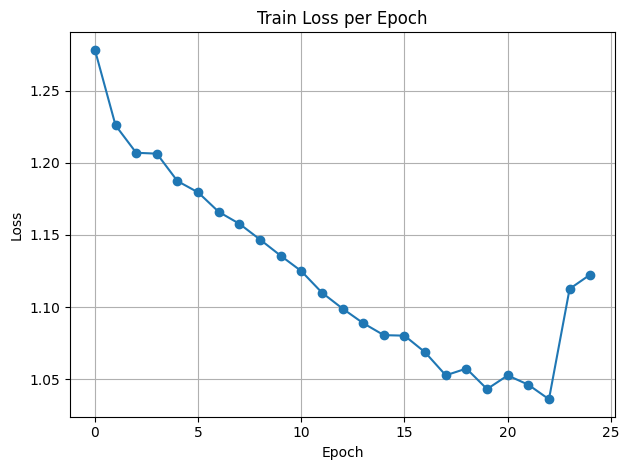

In [28]:

# --------------------------
# Save Model & Hyperparameters
# --------------------------
os.makedirs('./saved_models', exist_ok=True)
torch.save(model.state_dict(), './saved_models/lstm_brand1.pt')
torch.save({
    'input_dim': 8,
    'hidden_dim': 64,
    'num_layers': 2,
    'pos_weight': pos_weight.item(),
    'lr': 1e-2,
    'batch_size': 512,
    'epochs': num_epochs,
}, './saved_models/lstm_brand1_hparams.pt')

# --------------------------
# Plot Loss History
# --------------------------
plt.plot(loss_history, marker='o')
plt.title("Train Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
loss_history

[2.7948318688387688,
 2.7099255163825884,
 2.6655173532682497,
 2.6453363408266144,
 2.6377261483348455,
 2.6328262398146065,
 2.6207820357909766,
 2.616203119685441,
 2.614657456258559,
 2.6127449416697437]

<h1> Confusion Matrix 

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device).float()

            logits = model(X)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long()

            all_preds.extend(preds.cpu().numpy().astype(int))
            all_labels.extend(y.cpu().numpy().astype(int))


    # 📊 스코어 계산
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"📊 Confusion Matrix:\n{cm}")

    # 📈 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


✅ Accuracy: 0.7641
✅ F1 Score: 0.3032
📊 Confusion Matrix:
[[42838  9917]
 [ 4260  3085]]


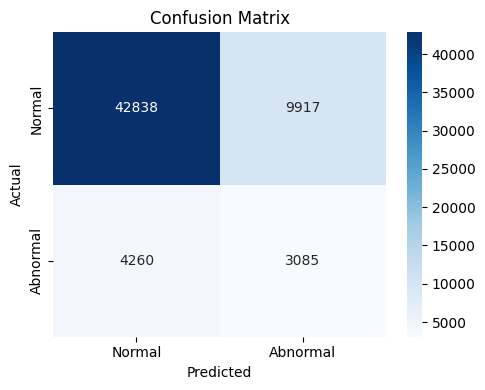

In [33]:
evaluate_model(model, test_loader, device)